"""
Created on Sun Sept  29 11:38:07 2024

@author: MIT Wind

Wake loss simulation, farm layout optimization, hydrogen exploration

Assumptions:
    No blockage effect considered. We are using Squared Sum Superposition for the wake models
    Any wake model considered uses the default parameters with which it was validated
"""

In [1]:
import numpy as np
import pandas as pd
from Site import Kratos,V236
from py_wake.deficit_models.gaussian import BastankhahGaussianDeficit
from py_wake.superposition_models import SquaredSum
from py_wake.wind_farm_models import PropagateDownwind
import os
from py_wake.utils.plotting import setup_plot
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from py_wake.flow_map import HorizontalGrid
from py_wake.examples.data import example_data_path
from scipy.spatial import ConvexHull
import utm
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm import TopFarmProblem
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint


/workspaces/Project-Development-Simualtion/generate_simulation_data.py:50: RuntimeWarning: invalid value encountered in divide
  Cp = power_array / (0.5 * rho * np.pi * swept_area* velocity_array**3)
/workspaces/Project-Development-Simualtion/generate_simulation_data.py:68: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a[k] = optimize.fsolve(Cp_a, Cp_guess, _Cp)[0]


[0.0, 0.0, 0.0, 0.0, 0.8802892059290688, 0.885937133507287, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888981170598, 0.8888888914943215, 0.6636873172984266, 0.5605789535927808, 0.48452211677003604, 0.4243801152724927, 0.37520262662609627, 0.33414977862499073, 0.29937672760798406, 0.2695944364054445, 0.24385843414103464, 0.22145328719723073, 0.20182351925795827, 0.18452953254120016, 0.16921806952188684, 0.15560165198323772, 0.14344383047163473, 0.1325483399593904, 0.12275096440851004, 0.11391332898171305, 0.10591809403819137, 0.0986651875123498, 0.09206881882100976, 0.08605508918537093, 0.08056006267636086, 0.07552819702737391, 0.07091105810555931, 0.0, 0.0, 0.0]


Decision Vairables

In [2]:
#only make changes here
n_wts = 16 # Number of turbines in the farm

#turbine specifications

Turbine_name = "V236"
hub_height = 113
diameter = 163
rated_ws = 8

cut_out_ws = 24
rated_power = 4.5
cut_in_ws = 3

#coordinates of the center point
center_latitude = 42.23501868
center_longitude = -74.02620093

latitudes = np.array([42.2016591, 42.2024431, 42.2136790,42.2815132,42.2795473,42.2524558,42.2561707,42.2371571,42.2142021,42.2113594])
longitudes = np.array([-74.0202118,-74.0075121,-73.9856404,-74.0394431,-74.0630615,-74.0553855,-74.0456429,-74.0164151,-74.0087391,-74.0199578]) 


/workspaces/Project-Development-Simualtion/generate_simulation_data.py:50: RuntimeWarning: invalid value encountered in divide
  Cp = power_array / (0.5 * rho * np.pi * swept_area* velocity_array**3)
/workspaces/Project-Development-Simualtion/generate_simulation_data.py:68: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a[k] = optimize.fsolve(Cp_a, Cp_guess, _Cp)[0]


<xarray.DataArray (sector: 12, ws: 5)> Size: 480B
array([[3.52774648e-02, 5.49502198e-02, 3.47509868e-02, 1.33319747e-02,
        3.38334252e-03],
       [2.53099771e-02, 1.60646240e-02, 4.81922307e-03, 9.58825885e-04,
        1.37240408e-04],
       [1.32828528e-02, 3.69868285e-03, 8.13659003e-04, 1.64262837e-04,
        3.16447714e-05],
       [1.21336304e-02, 2.17870980e-03, 1.87284076e-04, 1.31527245e-05,
        9.20681162e-07],
       [1.57018071e-02, 3.61351181e-03, 2.84177231e-04, 1.41624853e-05,
        5.58179853e-07],
       [2.58827207e-02, 1.35702462e-02, 3.76174192e-03, 7.36574843e-04,
        1.07788592e-04],
       [2.74269814e-02, 4.68490803e-02, 3.01933205e-02, 1.09441492e-02,
        2.42567916e-03],
       [1.85162738e-02, 4.24741910e-02, 3.77775373e-02, 1.97888189e-02,
        6.67321496e-03],
       [1.06334376e-02, 2.36814699e-02, 2.02856467e-02, 1.01189949e-02,
        3.21237435e-03],
       [1.15648233e-02, 2.28035455e-02, 2.02544837e-02, 1.21146553e-02,
        5.36963506e-03],
       [1.65041816e-02, 3.65105910e-02, 3.77505282e-02, 2.72154671e-02,
        1.49468874e-02],
       [2.19442659e-02, 5.46094972e-02, 5.44643727e-02, 3.33149905e-02,
        1.37465182e-02]])
Coordinates:
  * ws       (ws) float64 40B 2.5 7.5 12.5 17.5 22.5
  * sector   (sector) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    description:  Probability of wind flow case (i.e. wind direction and wind...

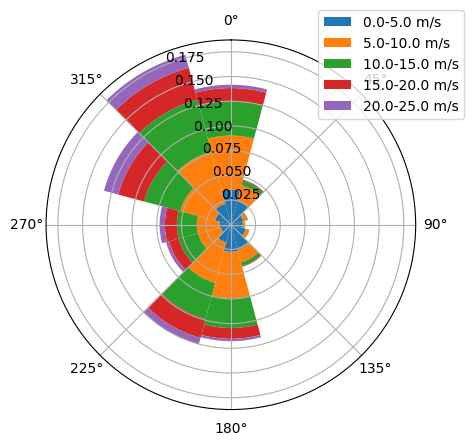

In [3]:
# Plot wind rose
turbine = V236(cut_in_ws ,rated_ws ,cut_out_ws ,rated_power ,diameter,Turbine_name, hub_height)
plt.figure()
site = Kratos(lat=center_latitude, long=center_longitude, height=hub_height,num_points=n_wts)
site.plot_wd_distribution(n_wd=12, ws_bins=[0,5,10,15,20,25])

Optimization Constraints

In [4]:
def hull_constraints(diam, boundary, n_wt=n_wts):
    """Constraints for Kratos

    n_wt : int, optional. Number of wind turbines in farm
    boundary: list of tuples representing vertices position

    Returns constr : list of topfarm constraints
        Currently only have Spacing constraint and boundary constraint
    """
    spac_constr = SpacingConstraint(3 * diam) # Minimum constraints
    bound_constr = XYBoundaryConstraint(boundary, 'convex_hull')
    return [spac_constr, bound_constr]

def bound_vertices(c_lat, c_lon):
    return np.array([*zip(c_lat, c_lon)])

Optimization

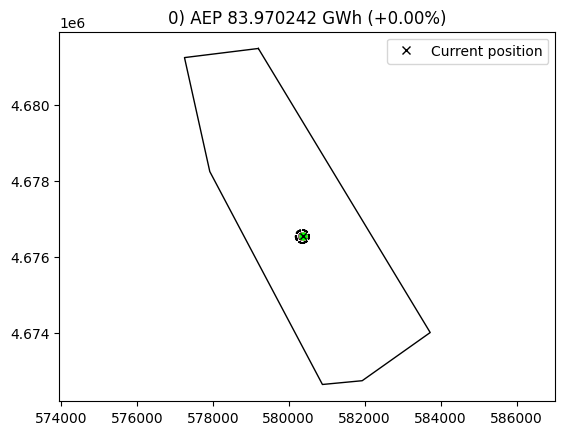

Iteration limit reached    (Exit mode 9)
            Current function value: -415.62791411276146
            Iterations: 200
            Function evaluations: 259
            Gradient evaluations: 201
Optimization FAILED.
Iteration limit reached
-----------------------------------


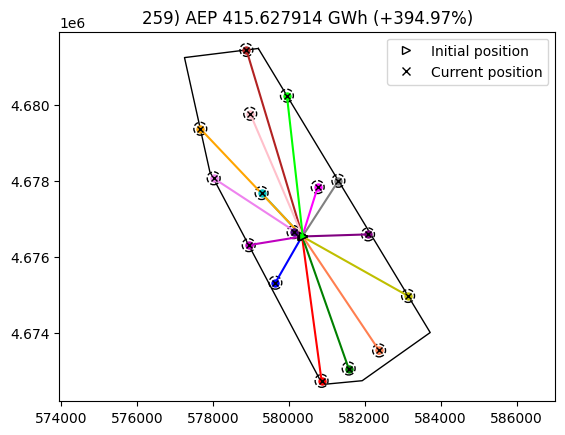

In [5]:
wfm = PropagateDownwind(site, turbine, wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=False),
                                        superpositionModel=SquaredSum(), deflectionModel=None) # Wind farm model

wt_x,wt_y , zone_number, zone_letter= site.initial_coordinates()


corner_x, corner_y, _, _= utm.from_latlon(latitudes,longitudes,zone_number, zone_letter)
# Use np.ascontiguousarray to ensure the memory layout is C-contiguous
objective = PyWakeAEPCostModelComponent(wfm, n_wts) # Wrapper for the objective function (AEP including wakes)
boundary_vertices = bound_vertices(corner_x, corner_y)
fixed_vertices = np.ascontiguousarray(boundary_vertices, dtype=np.float64)
constraints_comp = hull_constraints(hub_height, fixed_vertices)
tf = TopFarmProblem(
    design_vars={'x': wt_x, 'y': wt_y}, # Use wt_x, wt_y (or fixed versions if you prefer)
    driver=EasyScipyOptimizeDriver(),
    cost_comp=objective,
    # Pass the fixed constraints component
    constraints=constraints_comp, 
    plot_comp=XYPlotComp(plot_initial=True),
)# TopFarm problem definition

cost, op_state, _= tf.optimize()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


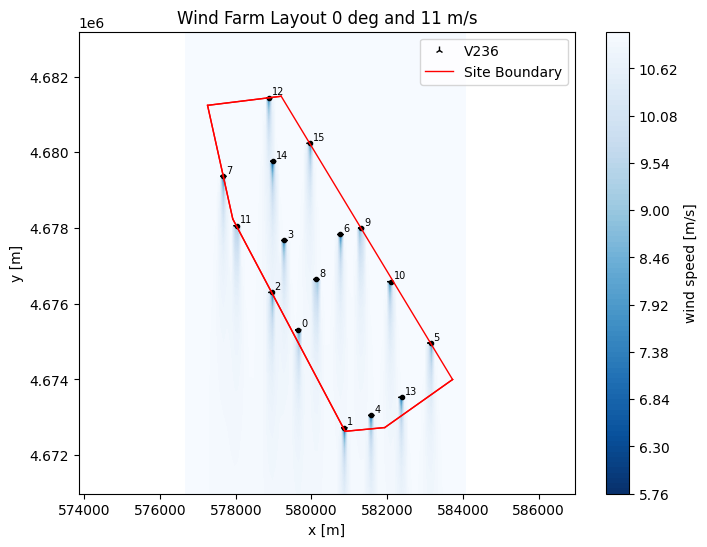

In [6]:
# Layout optimization visualization
wt_x_op, wt_y_op = op_state['x'], op_state['y'] # Optimized layout
sim_res_op = wfm(wt_x_op, wt_y_op) # Simulate result for optimize turbine placement

wdir = 0 # Wind direction to plot flow map
wsp = 11 # Wind speed to plot flow map

xmin = min(wt_x_op)-1000
xmax = max(wt_x_op)+1000
ymin = min(wt_y_op)-1000
ymax = max(wt_y_op)+1000
plt.figure(figsize=(8,6))
flow_map = sim_res_op.flow_map(HorizontalGrid(x = np.arange(xmin,xmax,100),),
                            wd=wdir,
                            ws = wsp).plot_wake_map()
# Combine x and y into an array of (x, y) points
points = np.column_stack((corner_x, corner_y))
hull = ConvexHull(points)

# Plot the convex hull by connecting the vertices in order
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-', linewidth=1)

# Close the loop by adding the first point to the end of the hull vertices
plt.plot(points[hull.vertices, 0], points[hull.vertices, 1], 'r-', linewidth=1, label='Site Boundary')

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wind Farm Layout'+ f' {wdir} deg and {wsp} m/s')
plt.xlim(xmin,xmax)
plt.legend()

The capacity factor is donated by:
$$\textbf{CF} = \frac{AEP}{n_{wts}\cdot P_{rated} \cdot N_{hours}}$$

In [7]:
# Wake Loss and Capacity factor of optimized farm
aep_with_wake_loss = sim_res_op.aep().sum().data
aep_without_wake_loss_time = sim_res_op.aep(with_wake_loss=False).sum().data
print(f"{aep_with_wake_loss=}")
print(f"{aep_without_wake_loss_time=}")
denom = n_wts*rated_power*8760/1000
aep_witout_wake_loss = sim_res_op.aep(with_wake_loss=False).sum().data
# print('total wake loss:',((aep_witout_wake_loss-aep_with_wake_loss) / aep_witout_wake_loss)*100, '%')
print('Capacity factor:', (aep_with_wake_loss/denom)*100, '%')

aep_with_wake_loss=array(415.62791411)
aep_without_wake_loss_time=array(422.46612933)
Capacity factor: 65.8973734958082 %


In [8]:
print((aep_without_wake_loss_time-aep_with_wake_loss)/aep_without_wake_loss_time*100)

1.6186422392422048


In [9]:
print(zone_number)
print(zone_letter)
wt_x_op_lat , wt_y_op_lon = utm.to_latlon(wt_x_op,wt_y_op,10, "S")
dict = {"latitudes": wt_x_op_lat, "longitudes": wt_y_op_lon}

data_frame=pd.DataFrame(dict)
data_frame.to_csv("turbine_location.csv")

18
T


In [ ]:
print(wt_x_op_lat)

[42.2350768  42.23501911 42.23628151 42.23646153 42.23606642 42.23558256
 42.23596794 42.23693626 42.23728619 42.23660467 42.23575411 42.23554354
 42.20003221 42.19985562 42.19840661 42.19794494 42.19837007 42.19762128
 42.19836018 42.19943988 42.19910387 42.19897342 42.20045036 42.20002871]


In [10]:
import numpy as np
from geopy.distance import geodesic

# Coordinates of the corner points (latitudes and longitudes)
latitudes = np.array([42.241220, 42.235171, 42.193742, 42.199795])
longitudes = np.array([-124.696095, -124.754752, -124.746961, -124.688304])

# Function to calculate the area of a polygon using the geodesic distances between points
def calculate_area(latitudes, longitudes):
    n = len(latitudes)
    area = 0.0
    for i in range(n):
        # Using the geodesic distance between consecutive points and cross-multiply
        j = (i + 1) % n  # next point index, wrapping around to 0 at the end
        p1 = (latitudes[i], longitudes[i])
        p2 = (latitudes[j], longitudes[j])
        # Geodesic distance between points
        distance = geodesic(p1, p2).meters
        # Accumulate area using the shoelace formula, but adjusted for geodesic distances
        area += latitudes[i] * longitudes[j] - latitudes[j] * longitudes[i]

    area = abs(area) / 2.0
    return area

# Calculate the area
area = calculate_area(latitudes, longitudes)
print(f"Area enclosed by the polygon: {area} square meters")


Area enclosed by the polygon: 0.0024771268795120704 square meters


Animation

### Financial Analysis (incomplete)

In [ ]:
# Cost analysis
from topfarm.cost_models.economic_models.turbine_cost import economic_evaluation as ee_2

# vectors for turbine properties: diameter, rated power and hub height. these are inputs to the cost model
Drotor_vector = [turbine.diameter()] * n_wts
power_rated_vector = [float(turbine.power(20))*1e-3] * n_wts
hub_height_vector = [turbine.hub_height()] * n_wts

# Additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
distance_from_shore = 25    # [km]
energy_price = 0.1               # [Euro/kWh] What we get per kWh
project_duration = 20            # [years]
rated_rpm_array = [16.1] * n_wts    # [rpm]
water_depth_array = [12] * n_wts  # [m]

aep_vector = np.array([sim_res_op.Power.sel(wt=0).sum().values/1e6,
                       sim_res_op.Power.sel(wt=1).sum().values/1e6,
                       sim_res_op.Power.sel(wt=2).sum().values/1e6,
                       sim_res_op.Power.sel(wt=3).sum().values/1e6])


# set up function for new cost model with initial inputs as set above
eco_eval = ee_2(Drotor_vector, power_rated_vector, hub_height_vector, aep_vector)
eco_eval.calculate_irr()
eco_eval.cost

print('Wind turbine configuration costs', eco_eval.cost)
print('IRR', eco_eval.IRR)

# just the cost bar lot
barplotvector = np.asarray([eco_eval.blade_B_costs[0], eco_eval.hub_cost[0], eco_eval.pitch_system_cost[0], eco_eval.nose_cone_cost[0],
                                eco_eval.bearing_cost[0], eco_eval.brake_and_coupling_cost[0], eco_eval.generator_cost[0],
                                eco_eval.variablespeed_electronics[0], eco_eval.yaw_system_cost[0], eco_eval.mainframe_cost[0],
                                eco_eval.platform_railing_cost[0], eco_eval.electrical_connection_cost[0],
                                eco_eval.hydraulic_cooling_system_cost[0], eco_eval.nacelle_cost[0], 35000,
                                eco_eval.tower_cost[0], eco_eval.foundation_cost[0], eco_eval.trasport_cost[0], eco_eval.roads_civil_cost_cost[0],
                                eco_eval.assembly_and_installation_cost[0], eco_eval.electrical_interface_cost[0]] / eco_eval.cost[0])
N = 21
ind = np.arange(N)  # the x locations for the groups
width = 0.5       # the width of the bars

plt.rcParams.update({'figure.autolayout': True})
fig, ax = plt.subplots()
ax.barh(ind, barplotvector, width, color='b')

# add some text for labels, title and axes ticks
ax.set_xlabel('Procentage of total costs [%]')
ax.set_title('Wind Turbine components costs')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(('Blades', 'Hub', 'Pitch System', 'Nose cone', 'Bearing', 'Break and coupling', 'Generator',
                    'Variable speed electornics', 'Yaw system', 'Mainframe', 'Platform railing', 'Electical connections',
                    'Hydraulic cooling systems', 'Nacelle cover', 'Control', 'Tower', 'Foundation', 'Transportation',
                    'Roads', 'Assembly and installation', 'Electrical interface'))
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 24 but corresponding boolean dimension is 4

In [ ]:
# We can do an analysis of the farm AEP if we have time series wind data
frame_8760 = pd.read_excel('8760.xlsx')
dir_120 = np.array(frame_8760['Dir_120'])
ws_120 = np.array(frame_8760['Spd_120'])
ti_120 = np.array(frame_8760['TI_120'])

time_stamp = np.arange(len(dir_120))/7.5/24

# Optimum wind farm simulation with 8760 data and 8 minute
sim_res_time = wfm(wt_x_op, wt_y_op, # wind turbine positions
                            wd=dir_120, # Wind direction time series
                            ws=ws_120, # Wind speed time series
                            time=time_stamp, # time stamps
                      )

hourly_output = np.empty(0) # Hourly power output from the farm
for ix in range(len(ws_120)):
    hourly_output = np.append(hourly_output,sim_res_time.Power.sel(wt=0, wd=dir_120[ix], ws= ws_120[ix], method='nearest').data/1e6*4 )

d = np.load(example_data_path + "/time_series.npz")
n_days=366
# plot time series
axes = plt.subplots(3,1, sharex=True, figsize=(16,10))[1]

for ax, (v,l) in zip(axes, [(dir_120, 'Wind direction [deg]'),(ws_120,'Wind speed [m/s]'),(hourly_output,'Hourly Output (MW)')]):
    ax.plot(time_stamp, v)
    ax.set_ylabel(l, fontsize= 18)
_ = ax.set_xlabel('Time [day]', fontsize= 18)